<a href="https://colab.research.google.com/github/purod/reinforcement_stock/blob/main/MystockTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [3]:
config.TRAIN_START_DATE

'2014-01-01'

In [ ]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [ ]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
df.shape

(94331, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.778782,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,45.615879,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.618542,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941105,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.475788,7117200,CAT,4


In [5]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [6]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [7]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [8]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [11]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [12]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [13]:
agent = DRLAgent(env = env_train)

### Model 1: A2C

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

### Set turbulence threshold

In [15]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [19]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [20]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [21]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.567686
std        43.785398
min         0.000000
25%        14.962223
50%        24.121876
75%        39.166582
max       652.443810
Name: turbulence, dtype: float64

In [22]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45832355660025

### Trade

In [23]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

In [26]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [27]:
df_account_value.shape

(336, 2)

In [28]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.377275e+06
332,2021-10-25,1.384688e+06
333,2021-10-26,1.382310e+06
334,2021-10-27,1.372886e+06
335,2021-10-28,1.384473e+06


In [29]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,100,0,0,0,0,0,100,43,0,21,...,0,1,100,17,59,0,100,0,0,98
2020-07-02,100,0,0,0,0,0,100,43,0,21,...,0,1,100,17,59,0,100,0,0,98
2020-07-06,100,0,0,0,0,0,100,43,0,21,...,0,1,100,17,59,0,100,0,0,98
2020-07-07,100,0,0,0,0,0,100,43,0,21,...,0,1,100,17,59,0,100,0,0,98
2020-07-08,100,0,0,0,0,0,100,43,0,21,...,0,1,100,17,59,0,100,0,0,98


In [31]:
df_actions.columns

Index(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS',
       'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK',
       'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'],
      dtype='object')

### Backtest our strategy

In [32]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.276331
Cumulative returns     0.384473
Annual volatility      0.130184
Sharpe ratio           1.945600
Calmar ratio           3.078260
Stability              0.860898
Max drawdown          -0.089769
Omega ratio            1.383769
Sortino ratio          2.954156
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.067255
Daily value at risk   -0.015397
dtype: float64


In [33]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,27.633%
Cumulative returns,38.447%
Annual volatility,13.018%
Sharpe ratio,1.95
Calmar ratio,3.08
Stability,0.86
Max drawdown,-8.977%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.98,2021-08-16,2021-10-04,NaT,NaN
1,8.16,2021-02-17,2021-03-04,2021-05-06,57
2,6.28,2020-10-12,2020-10-30,2020-11-11,23
3,6.26,2020-09-02,2020-09-21,2020-10-12,29
4,4.51,2021-01-12,2021-01-29,2021-02-17,27


Stress Events,mean,min,max
New Normal,0.10%,-2.94%,3.62%


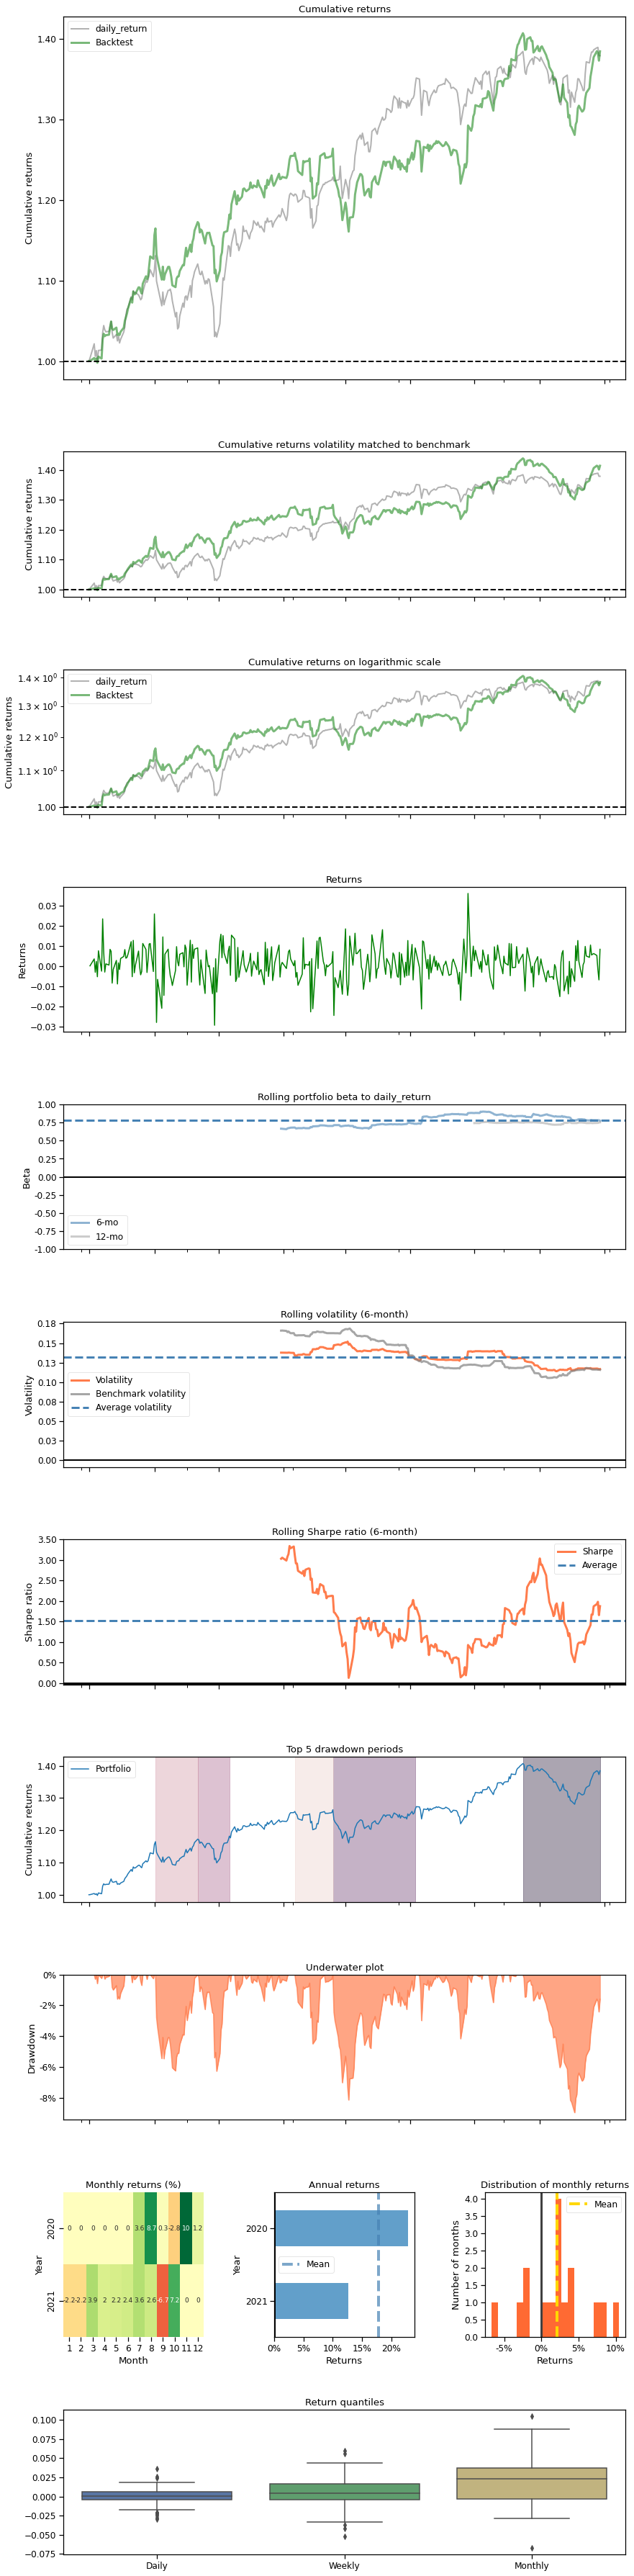

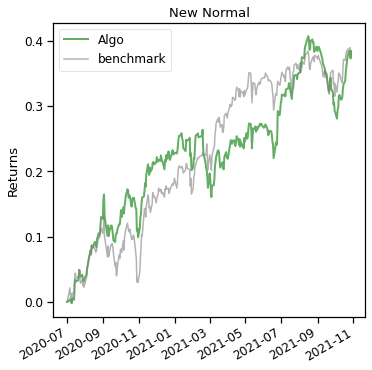

In [39]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])